In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load JSON data
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Discuswerper.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']
        bbox = annotation['bbox']

        if len(keypoints) % 3 != 0:
            # Skip invalid keypoints
            print(f"Skipping invalid keypoints in segment: {segment}")
            continue

        # Normalize keypoints using bbox dimensions
        normalized_keypoints = []
        for i in range(0, len(keypoints), 3):
            x = keypoints[i] / bbox[2]  # Normalize x by width
            y = keypoints[i + 1] / bbox[3]  # Normalize y by height
            visibility = keypoints[i + 2]  # Visibility
            normalized_keypoints.extend([x, y, visibility])

        if len(normalized_keypoints) == 51:  # Ensure all entries are of the same length
            features.append(normalized_keypoints)
            scores.append(details['score'])

# Convert to NumPy arrays
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Check consistency
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Initialize and train the model
model = create_model(X_train.shape[1])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Save the model
model.save("athlete_score_predictor.h5")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Discuswerper.json'

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.0191 - mae: 1.4239 - val_loss: 5.5599 - val_mae: 2.1272
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5189 - mae: 1.0041 - val_loss: 3.8408 - val_mae: 1.7279
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3721 - mae: 0.9597 - val_loss: 2.8792 - val_mae: 1.4619
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2794 - mae: 0.9312 - val_loss: 1.8681 - val_mae: 1.1625
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2599 - mae: 0.8957 - val_loss: 1.5366 - val_mae: 1.0355
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1541 - mae: 0.8727 - val_loss: 1.1899 - val_mae: 0.9219
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2758 - mae: 0.9139 - val_loss: 1.2230 - val_mae: 0.9000
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1725 - mae: 0.8773 - val_loss: 1.0286 - val_mae: 0.8341
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1381 - mae: 

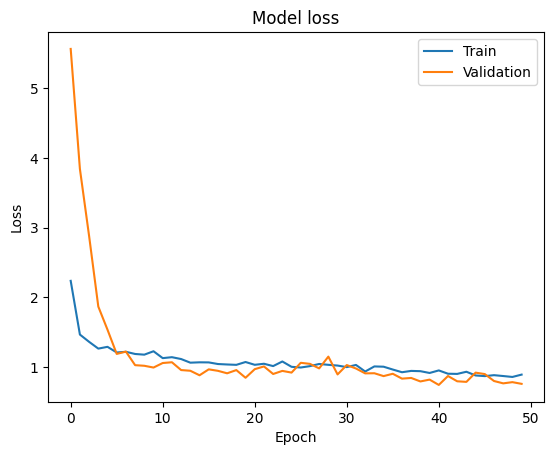

In [ ]:
import matplotlib.pyplot as plt

# Initialize and train the model
model = create_model(X_train.shape[1])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from ultralytics import YOLO
import cv2

# Load the YOLOv8 model for pose detection
model = YOLO('yolov8s-pose.pt')  # Load the YOLOv8 pose model

# Open video capture
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_001557.mp4'
cap = cv2.VideoCapture(video_path)

frame_idx = 0
keypoints_data = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run pose detection on the frame
    results = model(frame)

    # Extract keypoints for each detected person
    for result in results:  # loop over detections
        keypoints = result.keypoints  # Extract keypoints (x, y, visibility)
        bbox = result.boxes.xywh[0].cpu().numpy()  # Bounding box (x, y, w, h)

        # Ensure keypoints are valid and normalize them
        if len(keypoints) % 3 == 0:
            normalized_keypoints = []
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize x by width
                y = keypoints[i + 1] / bbox[3]  # Normalize y by height
                visibility = keypoints[i + 2]  # Visibility
                normalized_keypoints.extend([x, y, visibility])

            keypoints_data.append(normalized_keypoints)

    frame_idx += 1

# Close video capture
cap.release()


0: 640x640 1 person, 516.9ms
Speed: 23.6ms preprocess, 516.9ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 344.4ms
Speed: 4.8ms preprocess, 344.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 417.5ms
Speed: 3.5ms preprocess, 417.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 430.4ms
Speed: 2.9ms preprocess, 430.4ms inference, 13.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 371.2ms
Speed: 32.4ms preprocess, 371.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 467.7ms
Speed: 3.5ms preprocess, 467.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 470.8ms
Speed: 3.9ms preprocess, 470.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 469.8ms
Speed: 3.9ms preprocess, 469.8ms inference, 1.6ms postprocess per image

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Discuswerper.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define the scoring model
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Initialize and train the model
model = create_model(X_train.shape[1])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Save the model
model.save("athlete_score_predictor.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_004494.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/50


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5741 - mae: 1.9591 - val_loss: 5.0813 - val_mae: 1.9990
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8606 - mae: 1.0929 - val_loss: 2.9150 - val_mae: 1.4811
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6565 - mae: 1.0443 - val_loss: 1.8774 - val_mae: 1.1757
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4841 - mae: 0.9849 - val_loss: 1.5834 - val_mae: 1.1087
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4464 - mae: 0.9789 - val_loss: 1.5183 - val_mae: 1.0839
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3944 - mae: 0.9686 - val_loss: 1.2938 - val_mae: 0.9513
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2753 - mae: 0.8944 - val_loss: 1.3064 - val_mae: 0.9596
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2277 - mae: 0.9111 - val_loss: 1.2705 - val_mae: 0.9251
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3648 - mae: 0.9540 - va

Test Loss: 1.0361, Test MAE: 0.7862

0: 384x640 2 persons, 127.9ms
Speed: 2.0ms preprocess, 127.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

0: 384x640 2 persons, 94.8ms
Speed: 9.8ms preprocess, 94.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

0: 384x640 2 persons, 649.2ms
Speed: 91.5ms preprocess, 649.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

0: 384x640 2 persons, 255.8ms
Speed: 3.2ms preprocess, 255.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



2025-01-20 10:13:52.224 python[1970:52658] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-20 10:13:52.224 python[1970:52658] +[IMKInputSession subclass]: chose IMKInputSession_Modern


0: 384x640 2 persons, 181.2ms
Speed: 1.0ms preprocess, 181.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

0: 384x640 2 persons, 61.3ms
Speed: 1.5ms preprocess, 61.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 384x640 2 persons, 63.9ms
Speed: 1.0ms preprocess, 63.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 384x640 2 persons, 184.8ms
Speed: 1.0ms preprocess, 184.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 384x640 1 person, 64.7ms
Speed: 1.2ms preprocess, 64.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 384x640 1 person, 60.3ms
Speed: 1.1ms preprocess, 60.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 384x6

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Discuswerper.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Discurweper.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Discurweper/segment_010422.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.2065 - mae: 2.1478 - val_loss: 6.1974 - val_mae: 2.2377
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7406 - mae: 1.0779 - val_loss: 4.8670 - val_mae: 1.9424
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6025 - mae: 1.0354 - val_loss: 3.6157 - val_mae: 1.6734
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3611 - mae: 0.9642 - val_loss: 2.7431 - val_mae: 1.4355
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3141 - mae: 0.9415 - val_loss: 1.9962 - val_mae: 1.2233
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2341 - mae: 0.9140 - val_loss: 1.7296 - val_mae: 1.1471
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0764 - mae: 0.8355 - val_loss: 1.7342 - val_mae: 1.1506
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1400 - mae: 0.8750 - val_loss: 1.6379 - val_mae: 1.0956
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1165 - mae: 0.8

R² Score: 0.5075

0: 384x640 1 person, 50.3ms
Speed: 2.6ms preprocess, 50.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

0: 384x640 1 person, 68.5ms
Speed: 12.1ms preprocess, 68.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 384x640 1 person, 63.0ms
Speed: 1.4ms preprocess, 63.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 384x640 1 person, 62.5ms
Speed: 1.6ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

0: 384x640 1 person, 105.4ms
Speed: 1.3ms preprocess, 105.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

0: 384x640 1 person, 108.2ms
Speed: 7.7ms preprocess, 108.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Estafette.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Estafette.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Estafette/segment_002126.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.2341 - mae: 2.3330 - val_loss: 7.7276 - val_mae: 2.6143
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7877 - mae: 1.0635 - val_loss: 6.5183 - val_mae: 2.4208
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4443 - mae: 0.9234 - val_loss: 5.5765 - val_mae: 2.2533
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2861 - mae: 0.8676 - val_loss: 4.4046 - val_mae: 2.0182
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3309 - mae: 0.8758 - val_loss: 3.4764 - val_mae: 1.7910
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1396 - mae: 0.8088 - val_loss: 2.8468 - val_mae: 1.6088
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1689 - mae: 0.7962 - val_loss: 2.2606 - val_mae: 1.4046
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1562 - mae: 0.8159 - val_loss: 1.7502 - val_mae: 1.1887
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9772 - mae: 0.

R² Score: 0.4873

0: 640x640 1 person, 203.9ms
Speed: 2.1ms preprocess, 203.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 (no detections), 102.4ms
Speed: 1.7ms preprocess, 102.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 104.3ms
Speed: 2.1ms preprocess, 104.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 1 person, 220.2ms
Speed: 1.7ms preprocess, 220.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 1 person, 85.6ms
Speed: 1.6ms preprocess, 85.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 1 person, 207.5ms
Speed: 1.5ms preprocess, 207.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Average Score for th

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Hoogspringen.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Hoogspringen.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hoogspringen/segment_001127.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.7765 - mae: 2.1790 - val_loss: 7.3646 - val_mae: 2.4064
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0913 - mae: 1.1564 - val_loss: 5.5091 - val_mae: 2.0402
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7146 - mae: 1.0196 - val_loss: 4.6824 - val_mae: 1.8596
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7520 - mae: 1.0430 - val_loss: 3.5479 - val_mae: 1.5660
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6559 - mae: 0.9895 - val_loss: 3.0527 - val_mae: 1.4245
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4300 - mae: 0.9360 - val_loss: 2.6898 - val_mae: 1.3432
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4835 - mae: 0.9435 - val_loss: 2.1999 - val_mae: 1.1797
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3873 - mae: 0.9032 - val_loss: 2.2704 - val_mae: 1.2103
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3848 - mae: 0.

R² Score: 0.3993

0: 640x640 1 person, 94.4ms
Speed: 3.0ms preprocess, 94.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

0: 640x640 1 person, 201.6ms
Speed: 4.8ms preprocess, 201.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

0: 640x640 1 person, 104.0ms
Speed: 1.7ms preprocess, 104.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

0: 640x640 1 person, 99.4ms
Speed: 29.0ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 640x640 1 person, 136.4ms
Speed: 2.7ms preprocess, 136.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

0: 640x640 1 person, 184.6ms
Speed: 1.5ms preprocess, 184.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Hordelopen.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Hordelopen.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hordenlopen/segment_001695.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.5322 - mae: 2.3303 - val_loss: 9.8180 - val_mae: 2.9259
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1834 - mae: 1.1821 - val_loss: 7.5410 - val_mae: 2.5450
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7079 - mae: 1.0284 - val_loss: 5.7474 - val_mae: 2.1752
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6637 - mae: 1.0120 - val_loss: 4.0918 - val_mae: 1.7783
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4182 - mae: 0.9416 - val_loss: 3.3264 - val_mae: 1.5735
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2811 - mae: 0.8961 - val_loss: 3.1601 - val_mae: 1.5325
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3129 - mae: 0.8811 - val_loss: 2.1896 - val_mae: 1.2155
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2797 - mae: 0.8832 - val_loss: 1.9107 - val_mae: 1.1241
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1746 - mae: 0.

R² Score: 0.3519

0: 384x640 1 person, 178.5ms
Speed: 2.0ms preprocess, 178.5ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

0: 384x640 1 person, 55.4ms
Speed: 0.9ms preprocess, 55.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

0: 384x640 1 person, 148.0ms
Speed: 11.6ms preprocess, 148.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

0: 384x640 1 person, 62.2ms
Speed: 1.2ms preprocess, 62.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 384x640 1 person, 174.6ms
Speed: 0.8ms preprocess, 174.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

0: 384x640 1 person, 52.7ms
Speed: 0.8ms preprocess, 52.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Kogelstoten.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Kogelstoten.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Kogelstoten/segment_000265.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.9281 - mae: 2.4646 - val_loss: 6.9331 - val_mae: 2.4701
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7024 - mae: 1.0307 - val_loss: 5.7266 - val_mae: 2.2298
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1657 - mae: 0.8475 - val_loss: 4.2442 - val_mae: 1.9067
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9887 - mae: 0.7796 - val_loss: 3.3658 - val_mae: 1.6843
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8428 - mae: 0.7315 - val_loss: 2.6030 - val_mae: 1.4702
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7213 - mae: 0.6568 - val_loss: 2.3963 - val_mae: 1.4081
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - mae: 0.6303 - val_loss: 1.9346 - val_mae: 1.2538
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5547 - mae: 0.5757 - val_loss: 1.3652 - val_mae: 1.0013
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6163 - mae: 0.6

R² Score: 0.6781

0: 384x640 3 persons, 43.3ms
Speed: 0.8ms preprocess, 43.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 384x640 3 persons, 44.9ms
Speed: 1.6ms preprocess, 44.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 384x640 3 persons, 40.4ms
Speed: 0.8ms preprocess, 40.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 384x640 3 persons, 39.2ms
Speed: 0.7ms preprocess, 39.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 384x640 3 persons, 39.9ms
Speed: 0.7ms preprocess, 39.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 384x640 3 persons, 39.7ms
Speed: 0.8ms preprocess, 39.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Speerwerpen.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Speerwerpen.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Speerwerpen/segment_000734.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.5406 - mae: 2.4022 - val_loss: 8.2534 - val_mae: 2.6719
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3931 - mae: 0.9420 - val_loss: 6.9330 - val_mae: 2.4303
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3629 - mae: 0.9547 - val_loss: 4.5341 - val_mae: 1.9712
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1609 - mae: 0.8723 - val_loss: 3.4644 - val_mae: 1.7254
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9518 - mae: 0.7743 - val_loss: 2.5485 - val_mae: 1.4907
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9454 - mae: 0.7774 - val_loss: 1.9388 - val_mae: 1.3008
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8222 - mae: 0.7070 - val_loss: 1.5772 - val_mae: 1.1459
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7854 - mae: 0.6980 - val_loss: 1.4682 - val_mae: 1.0950
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7976 - mae: 0.7

R² Score: 0.6698

0: 384x640 2 persons, 49.8ms
Speed: 1.1ms preprocess, 49.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 384x640 2 persons, 53.6ms
Speed: 1.3ms preprocess, 53.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 384x640 2 persons, 36.1ms
Speed: 0.8ms preprocess, 36.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 384x640 2 persons, 38.3ms
Speed: 0.8ms preprocess, 38.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

0: 384x640 1 person, 35.7ms
Speed: 0.7ms preprocess, 35.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

0: 384x640 1 person, 36.9ms
Speed: 0.7ms preprocess, 36.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Sprint_Start.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Sprint_Start.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/sprint_start/segment_000091.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.5637 - mae: 2.5160 - val_loss: 10.9512 - val_mae: 3.2415
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5748 - mae: 0.9449 - val_loss: 7.8523 - val_mae: 2.7253
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0421 - mae: 0.7942 - val_loss: 5.3425 - val_mae: 2.2262
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7823 - mae: 0.6992 - val_loss: 3.5010 - val_mae: 1.7719
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6266 - mae: 0.6299 - val_loss: 2.1267 - val_mae: 1.3173
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5583 - mae: 0.6030 - val_loss: 1.5467 - val_mae: 1.1055
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5515 - mae: 0.5894 - val_loss: 0.8707 - val_mae: 0.8122
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4670 - mae: 0.5447 - val_loss: 0.6864 - val_mae: 0.7028
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4600 - mae: 0

R² Score: 0.5520

0: 640x640 1 person, 97.4ms
Speed: 3.1ms preprocess, 97.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

0: 640x640 1 person, 117.9ms
Speed: 2.4ms preprocess, 117.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 1 person, 82.4ms
Speed: 1.9ms preprocess, 82.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

0: 640x640 1 person, 130.6ms
Speed: 3.6ms preprocess, 130.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

0: 640x640 1 person, 253.9ms
Speed: 3.5ms preprocess, 253.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 640x640 1 person, 124.1ms
Speed: 2.7ms preprocess, 124.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Sprint.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Sprint.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/sprint/segment_000671.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.4250 - mae: 2.7061 - val_loss: 9.8258 - val_mae: 2.9392
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9793 - mae: 1.1100 - val_loss: 9.1721 - val_mae: 2.8701
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6300 - mae: 1.0295 - val_loss: 7.9005 - val_mae: 2.6514
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3214 - mae: 0.8919 - val_loss: 6.5940 - val_mae: 2.4093
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2281 - mae: 0.8585 - val_loss: 5.5273 - val_mae: 2.1977
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1849 - mae: 0.8482 - val_loss: 4.3365 - val_mae: 1.9084
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1186 - mae: 0.8201 - val_loss: 3.1918 - val_mae: 1.6019
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0556 - mae: 0.8366 - val_loss: 2.3523 - val_mae: 1.3443
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8084 - mae: 0.

R² Score: 0.5562

0: 384x640 1 person, 120.7ms
Speed: 2.5ms preprocess, 120.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 384x640 1 person, 66.5ms
Speed: 1.7ms preprocess, 66.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Average Score for the Video: 5.00


In [ ]:
import cv2
import numpy as np
import json
import tensorflow as tf
from ultralytics import YOLO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os

# Load JSON data for scoring model
file_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonScore/Verspringen.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Define the expected number of keypoints (e.g., 17 keypoints, each with x, y, and visibility)
expected_keypoints = 17
expected_size = expected_keypoints * 3  # Each keypoint has x, y, visibility (3 values)

# Extract features (keypoints) and labels (scores)
features = []
scores = []

for segment, details in data['segments'].items():
    for annotation in details['annotations']:
        keypoints = annotation['keypoints']  # Flatten keypoints
        normalized_keypoints = []

        # Normalize using bbox dimensions
        bbox = annotation['bbox']
        
        # Ensure that keypoints contain a valid number of elements (x, y, and visibility for each keypoint)
        if len(keypoints) % 3 == 0:  # Check that each keypoint has x, y, and visibility
            for i in range(0, len(keypoints), 3):
                x = keypoints[i] / bbox[2]  # Normalize by width
                y = keypoints[i + 1] / bbox[3]  # Normalize by height
                visibility = keypoints[i + 2]  # Keep visibility as-is
                normalized_keypoints.extend([x, y, visibility])

            # Pad or trim the keypoints list to the expected size
            if len(normalized_keypoints) > expected_size:
                normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
            elif len(normalized_keypoints) < expected_size:
                normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

            features.append(normalized_keypoints)
            scores.append(details['score'])
        else:
            print(f"Skipping annotation with invalid keypoint length: {len(keypoints)}")

# Convert to NumPy arrays (after ensuring consistency)
X = np.array(features, dtype=np.float32)
y = np.array(scores, dtype=np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler and save the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaler_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl"  # Correct path for saving the scaler
joblib.dump(scaler, scaler_path)  # Save the scaler
print(f"Scaler saved at {scaler_path}")

# Define a more complex model with added LSTM layers for sequential data
def create_model(input_dim):
    model = tf.keras.Sequential([
        # Reshape the input to be 3D for LSTM
        tf.keras.layers.Reshape((1, input_dim), input_shape=(input_dim,)),  # Reshape to (1, features)
        
        # LSTM layer for sequential data (even though you have one timestep)
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu'),
        
        # Dense layers for feature learning
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Initialize and train the model with early stopping
model = create_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Calculate R² score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Save the model
model.save("Verspringen.h5")

# Load YOLO model for pose estimation
pose_model = YOLO("yolov8n-pose.pt")

# Path to the video
video_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Verspringen/segment_001406.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
frame_scores = []

# Load the saved scaler for normalization of keypoints
if os.path.exists(scaler_path):
    scaler_scoring = joblib.load(scaler_path)
else:
    # If the scaler doesn't exist, fit a new one (this case should not happen if you have already saved it)
    scaler_scoring = MinMaxScaler(feature_range=(0, 1))
    scaler_scoring.fit(X)  # Use `X` as the keypoints data
    joblib.dump(scaler_scoring, scaler_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Step 1: Extract Keypoints
    results = pose_model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        continue

    keypoints = results[0].keypoints.xy.cpu().numpy().flatten()  # x, y coordinates
    if len(keypoints) == 0:
        continue  # Skip frames without valid keypoints

    # Step 2: Normalize keypoints using bounding box dimensions
    bbox = results[0].boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
    if bbox is None or len(bbox) != 4:
        continue  # Skip frames without valid bbox

    normalized_keypoints = []
    for i in range(0, len(keypoints), 2):  # Assuming keypoints are in x, y pairs
        x = keypoints[i] / bbox[2]  # Normalize by width
        y = keypoints[i + 1] / bbox[3]  # Normalize by height
        normalized_keypoints.extend([x, y])

    # Pad or trim the normalized keypoints to match the expected feature size (51 values)
    if len(normalized_keypoints) > expected_size:
        normalized_keypoints = normalized_keypoints[:expected_size]  # Trim if too long
    elif len(normalized_keypoints) < expected_size:
        normalized_keypoints += [0] * (expected_size - len(normalized_keypoints))  # Pad if too short

    # Step 3: Predict Score using the trained scoring model
    normalized_keypoints = np.array([normalized_keypoints], dtype=np.float32)

    # Normalize the features using the saved scaler
    normalized_keypoints = scaler_scoring.transform(normalized_keypoints)

    # Predict score from the model
    score = model.predict(normalized_keypoints).flatten()[0]

    # Clip the predicted score to ensure it's between 1 and 5
    score = np.clip(score, 1, 5)

    # Round the score to the nearest 0.5
    rounded_score = round(score * 2) / 2
    frame_scores.append(rounded_score)

    # Step 4: Annotate the frame with the score
    cv2.putText(frame, f"Score: {rounded_score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show frame
    frame_count += 1
    cv2.imshow('Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Step 5: Aggregate Results
average_score = np.mean(frame_scores) if frame_scores else 0
print(f"Average Score for the Video: {average_score:.2f}")


Scaler saved at /Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints/Testing/scoring_scaler7.pkl
Epoch 1/100


/opt/anaconda3/envs/athletes/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.6056 - mae: 2.4432 - val_loss: 10.7096 - val_mae: 3.1804
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5249 - mae: 0.9396 - val_loss: 8.8968 - val_mae: 2.8887
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3316 - mae: 0.8976 - val_loss: 7.8673 - val_mae: 2.7110
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9470 - mae: 0.7790 - val_loss: 6.2346 - val_mae: 2.3970
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9079 - mae: 0.7616 - val_loss: 4.5779 - val_mae: 2.0208
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8352 - mae: 0.7126 - val_loss: 3.4964 - val_mae: 1.7343
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6363 - mae: 0.6080 - val_loss: 2.1828 - val_mae: 1.3104
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7099 - mae: 0.6629 - val_loss: 1.7309 - val_mae: 1.1175
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6054 - mae: 0

R² Score: 0.3358

0: 640x640 1 person, 222.2ms
Speed: 2.2ms preprocess, 222.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

0: 640x640 1 person, 169.6ms
Speed: 12.5ms preprocess, 169.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 1 person, 190.8ms
Speed: 10.7ms preprocess, 190.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

0: 640x640 1 person, 166.6ms
Speed: 6.7ms preprocess, 166.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 640x640 1 person, 112.8ms
Speed: 2.8ms preprocess, 112.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

0: 640x640 1 person, 137.2ms
Speed: 6.6ms preprocess, 137.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━